# Heat solver

This notebook demonstrates basic usage of Tidy3D's heat solver. We will consider three simple multimaterial setups, planar, cylindrical, and spherical, and compare results to analytical solutions. 

Tidy3D's heat feature solves a steady-state heat equation:
$$ - k \nabla^2 T = s $$
with temperature and flux continuity conditions on the interfaces between different materials:
$$ T_1 = T_2 $$
$$ k_1 \frac{\partial T_1}{\partial n} = k_2 \frac{\partial T_2}{\partial n} $$
and subject to a set of boundary conditions on the simulation domain boundary consisting of the following types:
- Temperature (Dirichlet): $\displaystyle T = T_0$
- Heat flux (Neumann): $\displaystyle k \frac{\partial T}{\partial n} = f$
- Convection (Robin): $\displaystyle k \frac{\partial T}{\partial n} = c (T-T_0)$

Here, $k$ is the thermal conductivity, $s$ is the volumetric heat source, $T_0$ is the prescribed temperature value, $f$ is the prescribed heat flux, and $c$ is the convection heat transfer coefficient.

Package [tidy3d](https://pypi.org/project/tidy3d/) contains all necessary API for defining and running heat simulation on our servers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import tidy3d as td
import tidy3d.web as web


## Defining Simulation Scene

First, we define basic parameter of the simulation setups. In all three cases, we will consider two material layers: one from coordinate `r1` to `r0`, and the second one from `r0` to `r2`. Thermal conductivities of the two layers are defined by parameters `conductivity1` and `conductivity2`. Each layer contains a volumetric heat source with rate given by `source1` and `source2`, correspondingly. Finally, the temperature at the bottom of the first layer is set to `temperature1` while the temperature at the top of the second layer is `temperature2`. Parameters must be provided in units consistent with the spatial units used in Tidy3D, microns. In these tests we do not simulate some specific material, thus, vales of material properties are rather arbitrary.

<img src="img/heat_solver_schematic.png" width="700" alt="Schematic of heat simulation setups">

In [2]:
# basic parameters of simulation setups
r1 = 0.2  # um
r0 = 0.5  # um
r2 = 0.9  # um
conductivity1 = 15  # W / (um * K)
conductivity2 = 2  # W / (um * K)
source1 = 1000  # J / (um^3 * K)
source2 = 300  # J / (um^3 * K)
temperature1 = 400  # K
temperature2 = 300  # K


To create materials for heat simulations, one must use `heat_spec` field of medium classes. Acceptable types for this field are [SolidSpec](../_autosummary/tidy3d.SolidSpec.html) and [FluidSpec](../_autosummary/tidy3d.FluidSpec.html) that define solid and fluid materials from the point of view of heat simulation. Note that the heat equation is only solved inside materials with [SolidSpec](../_autosummary/tidy3d.SolidSpec.html), regions with [FluidSpec](../_autosummary/tidy3d.FluidSpec.html) or for which `heat_spec` is not provided at all are excluded in heat solver. Note that since currently Tidy3D supports only steady-state heat simulation parameter `capacity` will not have an effect on simulation results.

In [3]:
medium1 = td.Medium(
    heat_spec=td.SolidSpec(
        capacity=1,
        conductivity=conductivity1,
    ),
    name="solid1",
)

medium2 = td.Medium(
    heat_spec=td.SolidSpec(
        capacity=1,
        conductivity=conductivity2,
    ),
    name="solid2",
)

background_medium = td.Medium(
    heat_spec=td.FluidSpec(),
    name="fluid",
)


Let us first consider constructing structures for the planar case. We define three overlapping boxes, such that in the region from `x=0` to `x=1` we have a two layers consisting made of materials `medium1` and `medium2` on the background of `background_medium`.

In [4]:
planar_top_layer = td.Structure(
    geometry=td.Box(center=(0, 0, 0), size=(2 * r2, td.inf, td.inf)),
    medium=medium2,
    name="top_layer",
)

planar_bottom_layer = td.Structure(
    geometry=td.Box(center=(0, 0, 0), size=(2 * r0, td.inf, td.inf)),
    medium=medium1,
    name="bottom_layer",
)

planar_core = td.Structure(
    geometry=td.Box(center=(0, 0, 0), size=(2 * r1, td.inf, td.inf)),
    medium=background_medium,
    name="core",
)


Now we can define a [Scene](../_autosummary/tidy3d.Scene.html) that specifies problem geometry for the planar case and visualize it. The purpose of class [Scene](../_autosummary/tidy3d.Scene.html) is to allow visualization of simulation setups without providing physics-specific details such as sources, monitors, grid specifications, etc, and to provide an easy way to transfer simulation setups between different solvers.

In [5]:
scene_planar = td.Scene(
    structures=[planar_top_layer, planar_bottom_layer, planar_core],
    medium=background_medium,
)


Note that by default the region of plotting is determined automatically based on present in [Scene](../_autosummary/tidy3d.Scene.html) structures. If all structures have infinite extent along a given axis (y in this particular case), the plotting limits are set to (-1, 1).

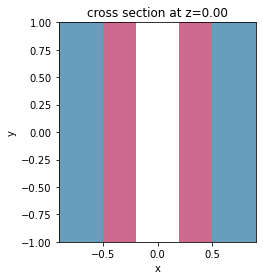

In [6]:
scene_planar.plot(z=0)
plt.show()


Custom plotting limits can be specified by using arguments `vlim` and `hlim`.

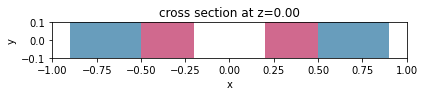

In [7]:
scene_planar.plot(z=0, vlim=[-0.1, 0.1], hlim=[-1, 1])
plt.show()


Analogously, we create three cylinders and three spheres in cylindrical and spherical cases, respectively.

In [8]:
cyl_top_layer = td.Structure(
    geometry=td.Cylinder(center=(0, 0, 0), length=1, radius=r2),
    medium=medium2,
    name="top_layer",
)

cyl_bottom_layer = td.Structure(
    geometry=td.Cylinder(center=(0, 0, 0), length=1, radius=r0),
    medium=medium1,
    name="bottom_layer",
)

cyl_core = td.Structure(
    geometry=td.Cylinder(center=(0, 0, 0), length=1, radius=r1),
    medium=background_medium,
    name="core",
)

scene_cyl = td.Scene(
    structures=[cyl_top_layer, cyl_bottom_layer, cyl_core],
    medium=background_medium,
)


In [9]:
sphere_top_layer = td.Structure(
    geometry=td.Sphere(center=(0, 0, 0), radius=r2),
    medium=medium2,
    name="top_layer",
)

sphere_bottom_layer = td.Structure(
    geometry=td.Sphere(center=(0, 0, 0), radius=r0),
    medium=medium1,
    name="bottom_layer",
)

sphere_core = td.Structure(
    geometry=td.Sphere(center=(0, 0, 0), radius=r1),
    medium=background_medium,
    name="core",
)

scene_sphere = td.Scene(
    structures=[sphere_top_layer, sphere_bottom_layer, sphere_core],
    medium=background_medium,
)


Note that besides function `.plot()` that paints structures with colors not related to physical properties, there is also function `.plot_heat_conductivity()` that uses the heat conductivity of each structure to select a grayscale color for it. Note that regions where the heat equation is not solved ([FluidSpec](../_autosummary/tidy3d.FluidSpec.html) or `heat_spec=None`) are displayed using light blue hatching.

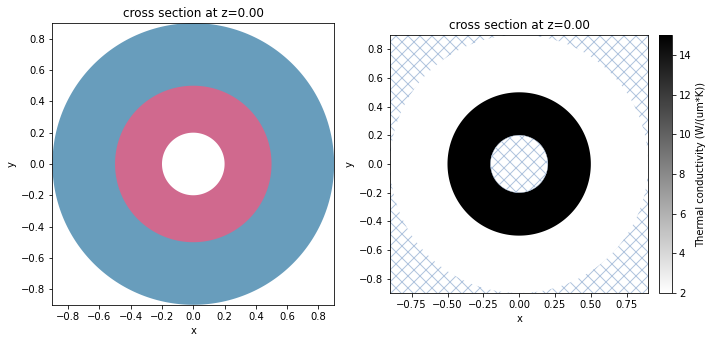

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
scene_cyl.plot(z=0, ax=ax[0])
scene_sphere.plot_heat_conductivity(z=0, ax=ax[1])
plt.tight_layout()
plt.show()


## Defining Heat Simulation

Now we proceed to defining a specification for actual heat simulations. We begin with setting simulation domain sizes for each case. Since planar and cylindrical cases are essentially one- and two-dimensional setups, correspondingly, we set a small domain size along invariant directions.

In [11]:
# simulation domain parameters

planar_sim_center = (0, 0, 0)
planar_sim_size = (2, 0.1, 0.1)

cyl_sim_center = (0, 0, 0)
cyl_sim_size = (2, 2, 0.1)

sphere_sim_center = (0, 0, 0)
sphere_sim_size = (2, 2, 2)


### Boundary Conditions
Boundary conditions for heat simulation are defined using class [HeatBoundarySpec](../_autosummary/tidy3d.HeatBoundarySpec.html) that has two required field `condition` and `placement`. The first one defines what boundary conditions should be imposed and accept types [TemperatureBC](../_autosummary/tidy3d.TemperatureBC.html), [HeatFluxBC](../_autosummary/tidy3d.TemperatureBC.html), or [ConvectionBC](../_autosummary/tidy3d.TemperatureBC.html). While the second one specifies where exactly it should be applied. Available options for that are:
- [StructureBoundary](../_autosummary/tidy3d.StructureBoundary.html): boundary of a structure. Only the portion of boundary not covered by subsequent structures is implied.
- [StructureStructureInterface](../_autosummary/tidy3d.StructureStructureInterface.html): interface between two structures. Specifically, the portion of boundary of the succeeding structure inside the preceding structure is implied.
- [MediumMediumInterface](../_autosummary/tidy3d.MediumMediumInterface.html): interface between two media.
- [SimulationBoundary](../_autosummary/tidy3d.SimulationBoundary.html): boundary of heat simulation domain. Note that specific surfaces of simulation box can be chosen using field `surfaces`. For example: `SimulationBoundary(surfaces=["z+", "z-"])`. By default, all surfaces are selected.
- [StructureSimulationBoundary](../_autosummary/tidy3d.StructureSimulationBoundary.html): part of boundary of heat simulation domain covered by a structure. Again, only the portion of boundary not covered by subsequent structures is implied.

Note that to point at a particular structure or medium, one must set in their definitions field `name` and use it when creating a boundary condition placement.

For these simulations we set temperature boundary conditions on the top of upper layer and the bottom of the lower layer. We also explicitly set adiabatic boundary conditions on the simulation domain boundary. Note that any solution domain boundaries, which include simulation domain boundary and boundaries facing mediums with empty or [FluidSpec](../_autosummary/tidy3d.FluidSpec.html) type `heat_spec`, are assigned adiabatic boundary conditions if no other boundary conditions is specified. Thus, setting adiabatic boundary conditions on the simulation domain boundary is not necessary in these simulations and is only done for demonstration purposes.

In [12]:
bc_side = td.HeatBoundarySpec(
    condition=td.HeatFluxBC(flux=0),
    placement=td.SimulationBoundary(),
)

bc_top = td.HeatBoundarySpec(
    condition=td.TemperatureBC(temperature=temperature2),
    placement=td.StructureBoundary(structure="top_layer"),
)

bc_bottom = td.HeatBoundarySpec(
    condition=td.TemperatureBC(temperature=temperature1),
    placement=td.StructureStructureInterface(structures=["core", "bottom_layer"]),
)


Note also that, for example, in case of `bc_bottom` we could have equivalently set `placement` to be `td.StructureBoundary(structure="core")` or `td.MediumMediumInterface(mediums=["solid1", "fluid"])`.

### Sources

We define volumetric heat source in each of the layers using [UniformHeatSource](../_autosummary/tidy3d.UniformHeatSource.html). Similarly to boundary conditions placement, heat sources are assigned to structures by using their names.

In [13]:
source_bottom = td.UniformHeatSource(structures=["bottom_layer"], rate=source1)
source_top = td.UniformHeatSource(structures=["top_layer"], rate=source2)


### Monitors

Like in optic Tidy3D simulations, the results of calculations are stored using monitors. Currently, heat simulations support [TemperatureMonitor](../_autosummary/tidy3d.TemperatureMonitor.html) that record spatial temperature distributions in chosen rectangular region. For convenience, even though the heat equation is solved on unstructured grids, [TemperatureMonitor](../_autosummary/tidy3d.TemperatureMonitor.html)'s return simulation results on equivalent Cartesian grids.

In [14]:
temp_mnt = td.TemperatureMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, td.inf), name="temperature"
)


### [HeatSimulation](../_autosummary/tidy3d.HeatSimulation.html) class

Combining purely geometric information about the simulation setup ([Scene](../_autosummary/tidy3d.Scene.html)) and heat solver specific definitions we can create [HeatSimulation](../_autosummary/tidy3d.HeatSimulation.html) instance for each of the three cases. Structures and background medium of a [Scene](../_autosummary/tidy3d.Scene.html) can either passed directly to a [HeatSimulation](../_autosummary/tidy3d.HeatSimulation.html) instance or a convenience method `.from_scene()` can be used. Note that in these examples we can make use of field `symmetry` to reduce the size and cost of simulations.

In [15]:
heat_sim_planar = td.HeatSimulation(
    center=planar_sim_center,
    size=planar_sim_size,
    medium=scene_planar.medium,
    structures=scene_planar.structures,
    boundary_spec=[bc_top, bc_bottom, bc_side],
    sources=[source_bottom, source_top],
    grid_spec=td.UniformUnstructuredGrid(dl=0.02),
    monitors=[temp_mnt],
    symmetry=(1, 0, 0),
)

heat_sim_cyl = td.HeatSimulation.from_scene(
    center=cyl_sim_center,
    size=cyl_sim_size,
    scene=scene_cyl,
    boundary_spec=[bc_top, bc_bottom, bc_side],
    sources=[source_bottom, source_top],
    grid_spec=td.UniformUnstructuredGrid(dl=0.02),
    monitors=[temp_mnt],
    symmetry=(1, 1, 0),
)

heat_sim_sphere = td.HeatSimulation.from_scene(
    center=sphere_sim_center,
    size=sphere_sim_size,
    scene=scene_sphere,
    boundary_spec=[bc_top, bc_bottom, bc_side],
    sources=[source_bottom, source_top],
    grid_spec=td.UniformUnstructuredGrid(dl=0.02),
    monitors=[temp_mnt],
    symmetry=(1, 1, 1),
)


Plotting function of [HeatSimulation](../_autosummary/tidy3d.HeatSimulation.html) displays heat conductivity information of structures using gray scale colors, assigned boundary conditions using thick lines (orange for [TemperatureBC](../_autosummary/tidy3d.TemperatureBC.html), green for [HeatFlxBC](../_autosummary/tidy3d.HeatFlxBC.html), and brown for [ConvectionBC](../_autosummary/tidy3d.ConvectionBC.html)), and heat sources as colored dots. Specifying `colorbar="conductivity"` or `colorbar="source"` changes the colorbar accordingly.

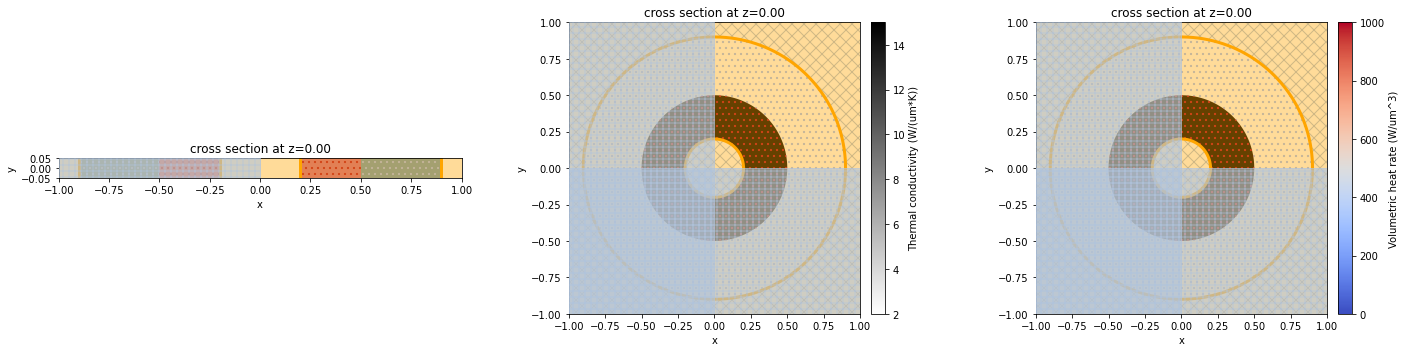

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
heat_sim_planar.plot(z=0, ax=ax[0])
heat_sim_cyl.plot_heat_conductivity(z=0, ax=ax[1], colorbar="conductivity")
heat_sim_sphere.plot_heat_conductivity(z=0, ax=ax[2], colorbar="source")
plt.tight_layout()
plt.show()


## Solving

Now we can submit the three heat simulation to our servers for solving. Heat simulations share the same web API as optic simulations. That is, we can submit simulations to servers in three ways.

The first way is to use function [web.run()](../_autosummary/tidy3d.web.run.html), which returns simulation results as a [HeatSimulationData](../_autosummary/tidy3d.HeatSimulationData.html) instance.

In [17]:
heat_sim_data_planar = web.run(simulation=heat_sim_planar, task_name="heat_sim_planar")


15:43:59 CDT Created task 'heat_sim_planar' with task_id                        
             'he-cb7a29d5-1b2f-44e3-bd4f-37fdd936d9dfv1' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. All heat      
             simulations are charged a flat fee of 0.025 FlexCredit.

Output()

15:44:00 CDT Heat solver status: queued

15:44:05 CDT Heat solver status: preprocess

15:44:54 CDT Heat solver status: running

15:44:57 CDT Heat solver status: postprocess

15:45:08 CDT Heat solver status: success

Output()

15:45:09 CDT loading simulation from simulation_data.hdf5

Alternatively, one can use [Job](../_autosummary/tidy3d.web.Job.html) container.

In [17]:
job = web.Job(simulation=heat_sim_cyl, task_name="heat_sim_cyl")
estimate_cost = job.estimate_cost()
heat_sim_data_cyl = job.run()


13:23:02 PDT Created task 'heat_sim_cyl' with task_id                           
             'he-81d469dc-49a5-47ca-a872-cc7c53d102cdv1' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. All heat      
             simulations are charged a flat fee of 0.025 FlexCredit.

Output()

             Maximum FlexCredit cost: 0.025. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

Finally, class [Batch](../_autosummary/tidy3d.web.Batch.html) facilitates a convenient submission of multiple simulations. Let us, for example, submit the spherical case at several different mesh resolutions.

In [19]:
dl_refine = [0.04, 0.02, 0.01, 0.005]
heat_sim_sphere_refine = {
    "heat_sim_sphere_"
    + str(dl): heat_sim_sphere.updated_copy(grid_spec=td.UniformUnstructuredGrid(dl=dl))
    for dl in dl_refine
}


In [20]:
batch = web.Batch(simulations=heat_sim_sphere_refine)
batch_data = batch.run()
heat_sim_data_sphere = batch_data["heat_sim_sphere_0.02"]


             Created task 'heat_sim_sphere_0.04' with task_id                   
             'he-a8e115a9-7b7e-4a3d-b2e1-896167e946a5v1' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. All heat      
             simulations are charged a flat fee of 0.025 FlexCredit.

Output()

15:46:40 CDT Created task 'heat_sim_sphere_0.02' with task_id                   
             'he-31347e82-a101-4bf5-ac91-1ec2f5a38672v1' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. All heat      
             simulations are charged a flat fee of 0.025 FlexCredit.

Output()

15:46:41 CDT Created task 'heat_sim_sphere_0.01' with task_id                   
             'he-cc1169f8-f8ae-4304-93ab-95c9b4ac8958v1' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. All heat      
             simulations are charged a flat fee of 0.025 FlexCredit.

Output()

15:46:42 CDT Created task 'heat_sim_sphere_0.005' with task_id                  
             'he-28aeac5b-6008-4649-86c7-be4db68ac2f9v1' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. All heat      
             simulations are charged a flat fee of 0.025 FlexCredit.

Output()

15:46:44 CDT Started working on Batch.

15:46:46 CDT Maximum FlexCredit cost: 0.100 for the whole batch. Use            
             'Batch.real_cost()' to get the billed FlexCredit cost after the    
             Batch has completed.

Output()

15:51:21 CDT Batch complete.

Output()

15:51:23 CDT loading simulation from                                            
             ./he-31347e82-a101-4bf5-ac91-1ec2f5a38672v1.hdf5

For more details on Tidy3D's web API see [the corresponding tutorial](https://www.flexcompute.com/tidy3d/examples/notebooks/WebAPI/).

## Data Visualization and Analysis

The solution data to the heat equation is stored in [HeatSimulationData](../_autosummary/tidy3d.HeatSimulationData.html) object. Its field `.data` contains `HeatMonitorData` instances corresponding to each monitor from `HeatSimulation.monitor`. Note that the heat equation is solved on an unstructured mesh, however, for a more convenient manipulation of data in the Tidy3D python client, the solution results are transferred onto a Cartesian grid. Temperature distribution corresponding to a given monitor can be visualized using function `HeatSimulationData.plot_data()`. Note that numerical solutions are slightly extrapolated outside of solution domains, such that interpolation can be accurately performed anywhere in the vicinity of the solution domain. Additionally, data in monitor data objects are automatically expanded with the respect to the symmetry of the original simulation.

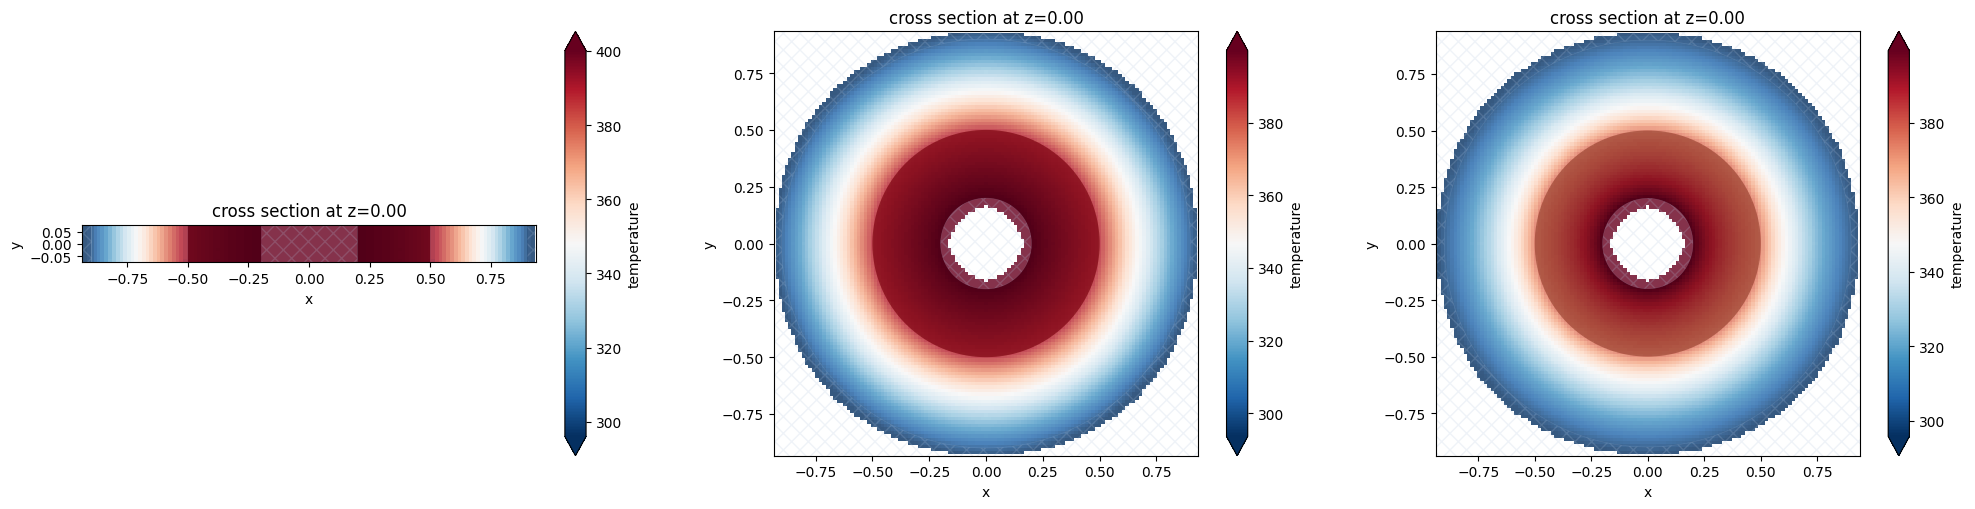

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

heat_sim_data_planar.plot_field("temperature", z=0, ax=ax[0])

heat_sim_data_cyl.plot_field("temperature", z=0, ax=ax[1])

heat_sim_data_sphere.plot_field("temperature", z=0, ax=ax[2])

plt.tight_layout()
plt.show()


Now let us compare the numerical results to analytical solutions. The general solution to the quasi one-dimensional steady-state heat equation in 1, 2 and 3 dimensions can be written as
$$ T_a(r) = - \frac1{2N} \frac{s}{k} r^2 + A u_N(r) + B,$$
where $N$ is the problem's dimensionality, $s$ is the source term, $k$ is the heat conductivity, $A$ and $B$ are coefficients defined by boundary conditions, and $u_N(r)$ is the Green function, which is given by 
$$ u_1(r) = r, \quad u_2(r) = \log(r), \quad u_3(r) = - \frac{1}{r}, $$
in one, two, and three dimensions, respectively. 

The analytical solutions $T(r)$ for the considered two-layer setups can be decomposed into two parts $T_1(r)$ and $T_2(r)$ such that
$$ T(r) = T_1(r),\, r < r_0$$
$$ T(r) = T_2(r),\, r > r_0$$
and each of which are given by the form $T_a(r)$ but with different coefficients $A_1$, $B_1$ and $A_2$, $B_2$. These are defined from boundary conditions:
$$T_1(r_1) = t_1,$$
$$T_2(r_2) = t_2,$$
$$T_1(r_0) = T_2(r_0),$$
$$k_1 \frac{d}{dr} T_1(r_0) = k_2\frac{d}{dr} T_2(r_0).$$
Thus, coefficients $A_1$, $A_2$, $B_1$, and $B_2$ can be found by solving linear system
$$
\begin{pmatrix}
u_N(r_1)& 1& 0& 0 \\
0& 0& u_N(r_2)& 1 \\
u_N(r_0)& 1& -u(r_0)& -1 \\
k_1 \frac{du_N}{dr}(r_0)& 0& -k_2 * \frac{du_N}{dr}(r_0)& 0
\end{pmatrix}
\begin{pmatrix}
A_1 \\ B_1 \\ A_2 \\ B_2
\end{pmatrix}
=
\begin{pmatrix}
t_1 + \frac1{2N} \frac{s_1}{k_1} r_1^2 \\
t_2 + \frac1{2N} \frac{s_2}{k_2} r_2^2 \\
\frac1{2N}  r_0^2 \left(\frac{s_1}{k_1} - \frac{s_2}{k_2}\right) \\
\frac1{N} r_0 (s_1 - s_2),
\end{pmatrix}
$$

In [22]:
# green functions of steady state heat equations in 1, 2, and 3 dimensions
u = [
    lambda r: r,
    lambda r: np.log(r),
    lambda r: -1.0 / r,
]

#  and their derivatives
du = [
    lambda r: 1,
    lambda r: 1.0 / r,
    lambda r: 1.0 / r**2,
]


Let us define a helper function that finds coefficients $A$ and $B$ from given boundary conditions.

In [23]:
def get_coeffs(u, du, N):
    """A helper function that finds coefficients of analytical solution in N dimensions."""

    # construct matrix
    mat = [
        [u(r1), 1, 0, 0],
        [0, 0, u(r2), 1],
        [u(r0), 1, -u(r0), -1],
        [conductivity1 * du(r0), 0, -conductivity2 * du(r0), 0],
    ]

    # construct right-hand side
    rhs = [
        temperature1 + 0.5 / N * source1 / conductivity1 * r1**2,
        temperature2 + 0.5 / N * source2 / conductivity2 * r2**2,
        0.5 / N * r0**2 * (source1 / conductivity1 - source2 / conductivity2),
        2 * 0.5 / N * r0 * (source1 - source2),
    ]

    A1, B1, B2, A2 = np.linalg.solve(mat, rhs)

    return A1, B1, B2, A2


And another helper function that samples analytical solution at given coordinate points.

In [24]:
def get_analytical(N, x):
    """A helper function that samples N-dimensional analytical solution at coordinates x."""

    A1, B1, A2, B2 = get_coeffs(u[N - 1], du[N - 1], N)

    x1_inds = np.logical_and(np.abs(x) >= r1, np.abs(x) < r0)
    x2_inds = np.logical_and(np.abs(x) >= r0, np.abs(x) <= r2)

    x1 = x[x1_inds]
    x2 = x[x2_inds]

    T1 = -0.5 / N * source1 / conductivity1 * x1**2 + A1 * u[N - 1](np.abs(x1)) + B1
    T2 = -0.5 / N * source2 / conductivity2 * x2**2 + A2 * u[N - 1](np.abs(x2)) + B2

    return np.concatenate((x1, x2)), np.concatenate((T1, T2))


Now we can easily find analytical solution for each of the cases and compare them to the numerical ones. Let us first perform this comparison for all three cases at resolution `dl = 0.02`.

In [25]:
x = heat_sim_data_planar["temperature"].temperature.coords["x"]
x_exact_planar, temperature_exact_planar = get_analytical(1, x)

x = heat_sim_data_cyl["temperature"].temperature.coords["x"]
x_exact_cyl, temperature_exact_cyl = get_analytical(2, x)

x = heat_sim_data_sphere["temperature"].temperature.coords["x"]
x_exact_sphere, temperature_exact_sphere = get_analytical(3, x)


As one can see the solver accurately reproduces analytical solutions.

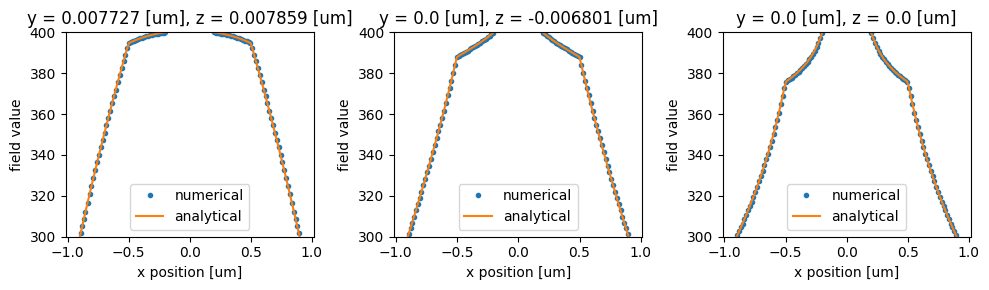

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

ax[0].plot(x_exact_planar, temperature_exact_planar, ".")
heat_sim_data_planar["temperature"].temperature.sel(z=0, y=0, method="nearest").plot(
    ax=ax[0]
)
ax[0].legend(["numerical", "analytical"])
ax[0].set_ylim([300, 400])

ax[1].plot(x_exact_cyl, temperature_exact_cyl, ".")
heat_sim_data_cyl["temperature"].temperature.sel(z=0, y=0, method="nearest").plot(
    ax=ax[1]
)
ax[1].legend(["numerical", "analytical"])
ax[1].set_ylim([300, 400])

ax[2].plot(x_exact_sphere, temperature_exact_sphere, ".")
heat_sim_data_sphere["temperature"].temperature.sel(z=0, y=0, method="nearest").plot(
    ax=ax[2]
)
ax[2].legend(["numerical", "analytical"])
ax[2].set_ylim([300, 400])

plt.tight_layout()
plt.show()


Now, let us look at the convergence of numerical solutions in the spherical case. Plotting the dependence of the solution error (in the $L_\infty$ norm) on the grid resolution we confirm the second order of convergence of the solver.

Output()

15:51:26 CDT loading simulation from                                            
             ./he-a8e115a9-7b7e-4a3d-b2e1-896167e946a5v1.hdf5

             loading simulation from                                            
             ./he-31347e82-a101-4bf5-ac91-1ec2f5a38672v1.hdf5

Output()

15:51:28 CDT loading simulation from                                            
             ./he-cc1169f8-f8ae-4304-93ab-95c9b4ac8958v1.hdf5

Output()

15:51:38 CDT loading simulation from                                            
             ./he-28aeac5b-6008-4649-86c7-be4db68ac2f9v1.hdf5

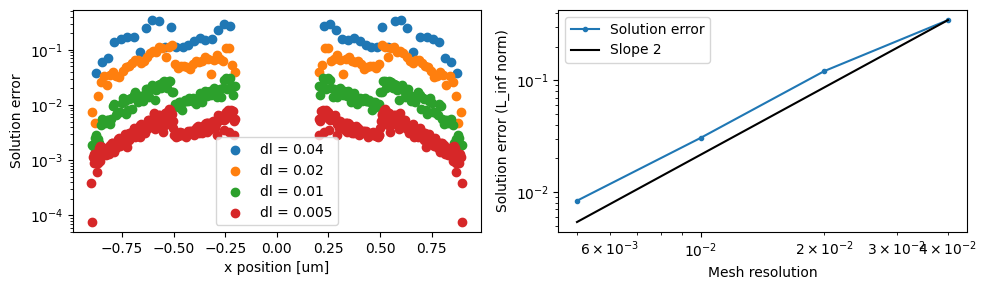

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
errors = []
for ind, (_, sim_data) in enumerate(batch_data.items()):
    x = sim_data["temperature"].temperature.coords["x"]
    x_exact_sphere, temperature_exact_sphere = get_analytical(3, x)
    temperature_numerical = sim_data["temperature"].temperature.interp(
        z=0, y=0, x=x_exact_sphere
    )
    error = (temperature_numerical - temperature_exact_sphere).abs
    errors.append(np.max(error))
    ax[0].scatter(x_exact_sphere, error, label=f"dl = {dl_refine[ind]}")

ax[0].set_yscale("log")
ax[0].set_xlabel("x position [um]")
ax[0].set_ylabel("Solution error")
ax[0].legend()

ax[1].loglog(dl_refine, errors, ".-", label="Solution error")
ax[1].loglog(
    dl_refine,
    errors[0].data * (np.array(dl_refine) / dl_refine[0]) ** 2,
    "-k",
    label="Slope 2",
)
ax[1].set_xlabel("Mesh resolution")
ax[1].set_ylabel("Solution error (L_inf norm)")
ax[1].legend()

plt.tight_layout()
plt.show()
